<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Автор материала: Дмитрий Сергеев, Zeptolab. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 9
## <center>Временные ряды

**Заполните код в клетках и выберите ответы в [веб-форме](https://docs.google.com/forms/d/1SIWHR6gDKLsmp4LuKeElAD_xtoW4-fzwkoqM-nuOvrU).**

Импортируем необходимые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Для работы возьмем реальные часовые данные по суммарному просмотру рекламы в одном из приложений.

In [2]:
df = pd.read_csv('../../data/ads_hour.csv',index_col=['Date'], 
                 parse_dates=['Date'])

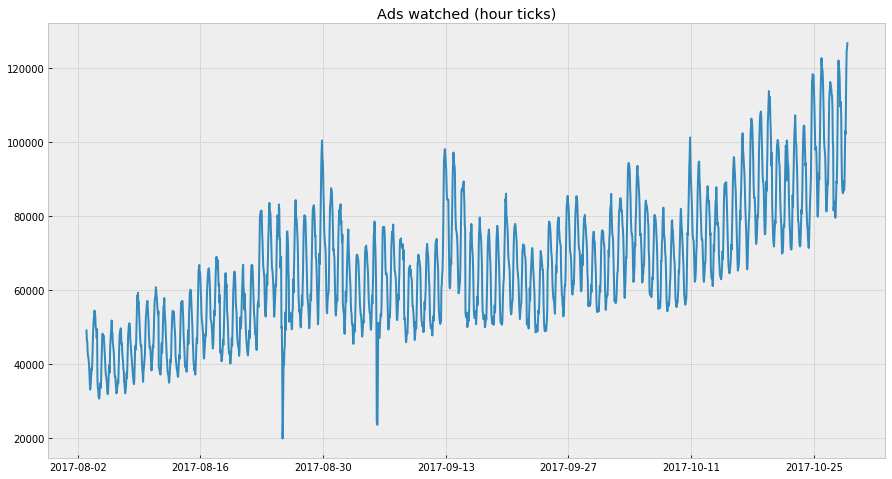

In [3]:
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Ads watched (hour ticks)')
    plt.plot(df.ads);

Тут есть и тренд, и различная сезонность, и немножко выбросов. 

В этом домашнем задании мы не будем пытаться подобрать наилучший ARIMA-процесс, порождающий наш ряд, и не затронем библиотеку Prophet от Facebook. Работа с этими методами очень подробна расписана во второй и третьей части ноутбуков по временным рядам в [репозитории](https://github.com/Yorko/mlcourse_open/tree/master/jupyter_russian/topic09_time_series) открытого курса по машинному обучению. 

А здесь мы сосредоточимся на построении и отборе признаков для временных рядов. 

Возьмем две полезные функции из [лекции](https://youtu.be/-iwjtvTxoVU) – для расчета среднего значения по таргету и для подготовки обучающего и тестового датасетов:

In [4]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(data, lag_start=5, lag_end=14, test_size=0.15, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data) * (1 - test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # выкидываем закодированные средними признаки 
        data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

Воспользуйтесь предложенными функциями и приготовьте из исходного датасета `df` необходимые для обучения датафреймы. Для тестирования отложите 30% данных, в качестве начального лага возьмите значения временного ряда 12 часов назад, а в качестве последнего лага - значения ряда 48 часов назад. Таким образом модель будет способна строить предсказания на 12 часов вперёд, имея фактические наблюдения за предыдущие полтора дня.


Также отмасштабируйте признаки, для этого воспользуйстесь `StandardScaler` и создайте переменные `X_train_scaled` и `X_test_scaled`. Не забудьте, что обучать scaler нужно только на тренировочной выборке, чтобы информация о средних отклонениях не просочилась из будущего в прошлое. 

In [5]:
# Ваш код здесь
X_train, X_test, y_train, y_test = prepareData(df, lag_start=12, lag_end=48, test_size=0.3)

In [6]:
X_train.head()

,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,hour,weekday,is_weekend
0,30781.0,30942.0,31387.0,33614.0,33534.0,36092.0,49502.0,47064.0,49061.0,49659.0,...,41136.0,42059.0,42281.0,43748.0,46355.0,46450.0,49136.0,23,4,0
1,32040.0,30781.0,30942.0,31387.0,33614.0,33534.0,36092.0,49502.0,47064.0,49061.0,...,39974.0,41136.0,42059.0,42281.0,43748.0,46355.0,46450.0,0,5,1
2,34229.0,32040.0,30781.0,30942.0,31387.0,33614.0,33534.0,36092.0,49502.0,47064.0,...,37261.0,39974.0,41136.0,42059.0,42281.0,43748.0,46355.0,1,5,1
3,34965.0,34229.0,32040.0,30781.0,30942.0,31387.0,33614.0,33534.0,36092.0,49502.0,...,35194.0,37261.0,39974.0,41136.0,42059.0,42281.0,43748.0,2,5,1
4,33603.0,34965.0,34229.0,32040.0,30781.0,30942.0,31387.0,33614.0,33534.0,36092.0,...,33188.0,35194.0,37261.0,39974.0,41136.0,42059.0,42281.0,3,5,1


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь обучите простую линейную регрессию на полученных данных:

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tsplt = TimeSeriesSplit(n_splits=5)
lin_reg = LinearRegression(n_jobs=-1)

Оценим качество работы линейной регрессии на тренировочной части при помощи кросс-валидации. Для этого необходимо сначала создать объект-генератор разбиений для временного ряда при помощи `TimeSeriesSplit`. Число фолдов задайте равным 5. Затем воспользуйтесь методом `cross_val_score`, передав туда в качестве параметра `cv` созданный генератор разбиений. Метрикой качества будет выступать `neg_mean_absolute_error`. 

Не забудьте взять среднее от полученного значения и домножить его на -1. 

In [9]:
# Ваш код здесь
tscv = cross_val_score(lin_reg, X_train_scaled, y_train, cv=tsplt, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=True)
tscv

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


array([-5472.53540649, -5566.82442968, -6186.5112431 , -4074.24771239,
       -4081.44032865])

In [10]:
-np.mean(tscv)

5076.311824059034

<font color='red'>Вопрос 1.</font> Чему равно среднее значение MAE на кросс-валидации?

- 4876
- 50962872
- 5076 
- 0.638

In [11]:
# Ответ: 3

Теперь посмотрим на результаты работы линейной регрессии на отложенной выборке. В этом нам поможет функция `plotModelResults`. В ней Вам нужно дописать часть, ответственную за расчет доверительных интервалов. Для расчета отклонения воспользуйтесь только что реализованным способом оценки качества на кросс-валидации – оттуда понадобится среднее значение MAE и стандартное отклонение этой величины. Доверительные интервалы строятся по формуле $\hat{y} \pm (\text{error} + scale * \text{standard deviation})$

In [12]:
def plotModelResults(model, _x_train, _x_test, plot_intervals=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(_x_test)
    
    plt.figure(figsize=(20, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        # Ваш код здесь
        cv = cross_val_score(model, _x_train, y_train, cv=tsplt, scoring='neg_mean_absolute_error', n_jobs=-1)

        mae = -np.mean(cv)
        deviation = np.std(cv) 
                
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    mae  = mean_absolute_error(prediction, y_test)
    mape = mean_absolute_percentage_error(prediction, y_test)
    plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))
    plt.legend(loc="best")
    plt.grid(True);

Для визуализации коэффициентов модели воспользуйтесь следующими функциями:

In [13]:
def getCoefficients(model):
    """
    Возвращает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)    
    

def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    coefs = getCoefficients(model)
    
    plt.figure(figsize=(20, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [14]:
lin_reg.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

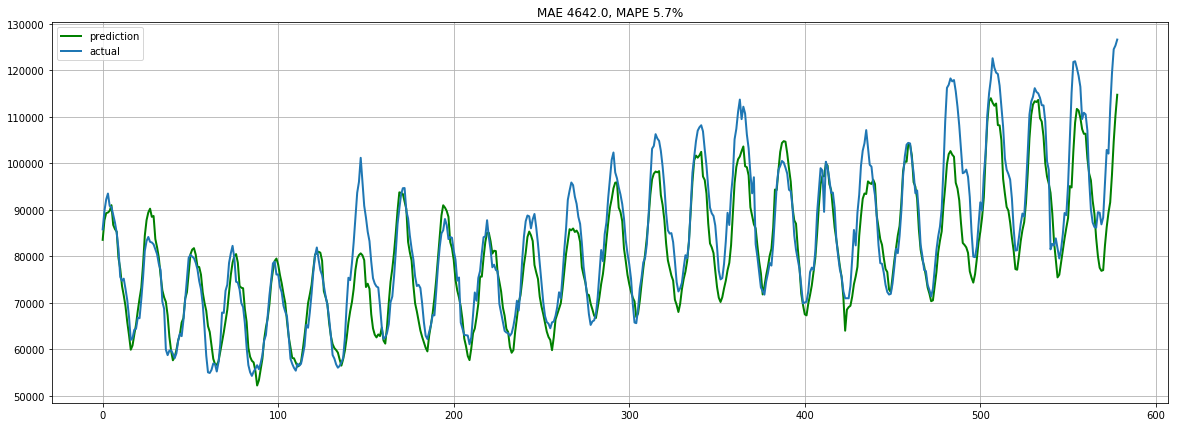

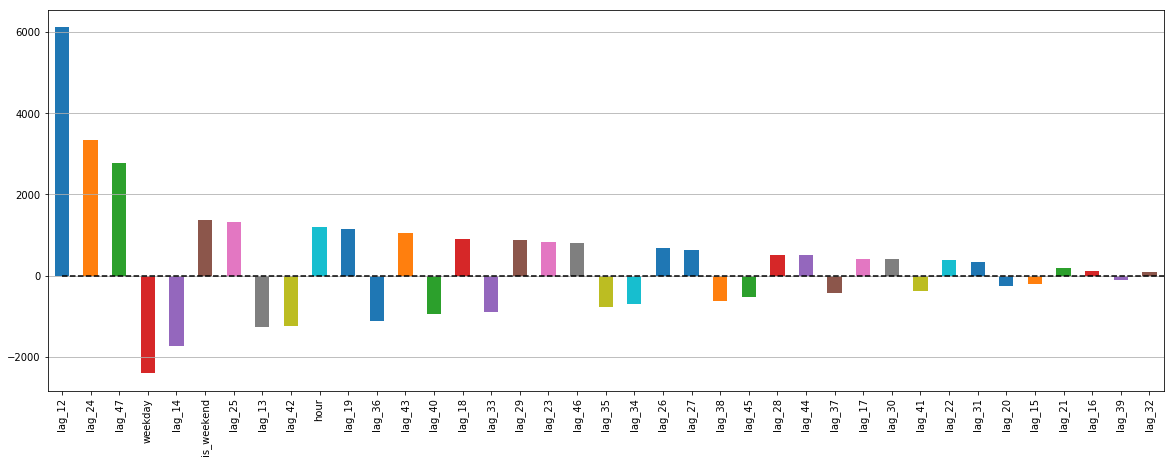

In [15]:
plotModelResults(lin_reg, X_train_scaled, X_test_scaled, plot_intervals=False)
plotCoefficients(lin_reg)

In [16]:
# plotModelResults(lin_reg, X_train_scaled, X_test_scaled, plot_intervals=False)
# plotCoefficients(lin_reg)

Замечательно, интервалы построены, прогнозы достаточно точные, и всё бы хорошо, если бы не одно но. В модели сейчас находится множество признаков и, возможно, какие-то из них лишние, а если их убрать, качество модели серьезно не пострадает. Чтобы убедиться, что у нас есть лишние признаки, постройте тепловую карту корреляций по `X_train`, поспользовавшись функцией `heatmap` из библиотеки `seaborn`:

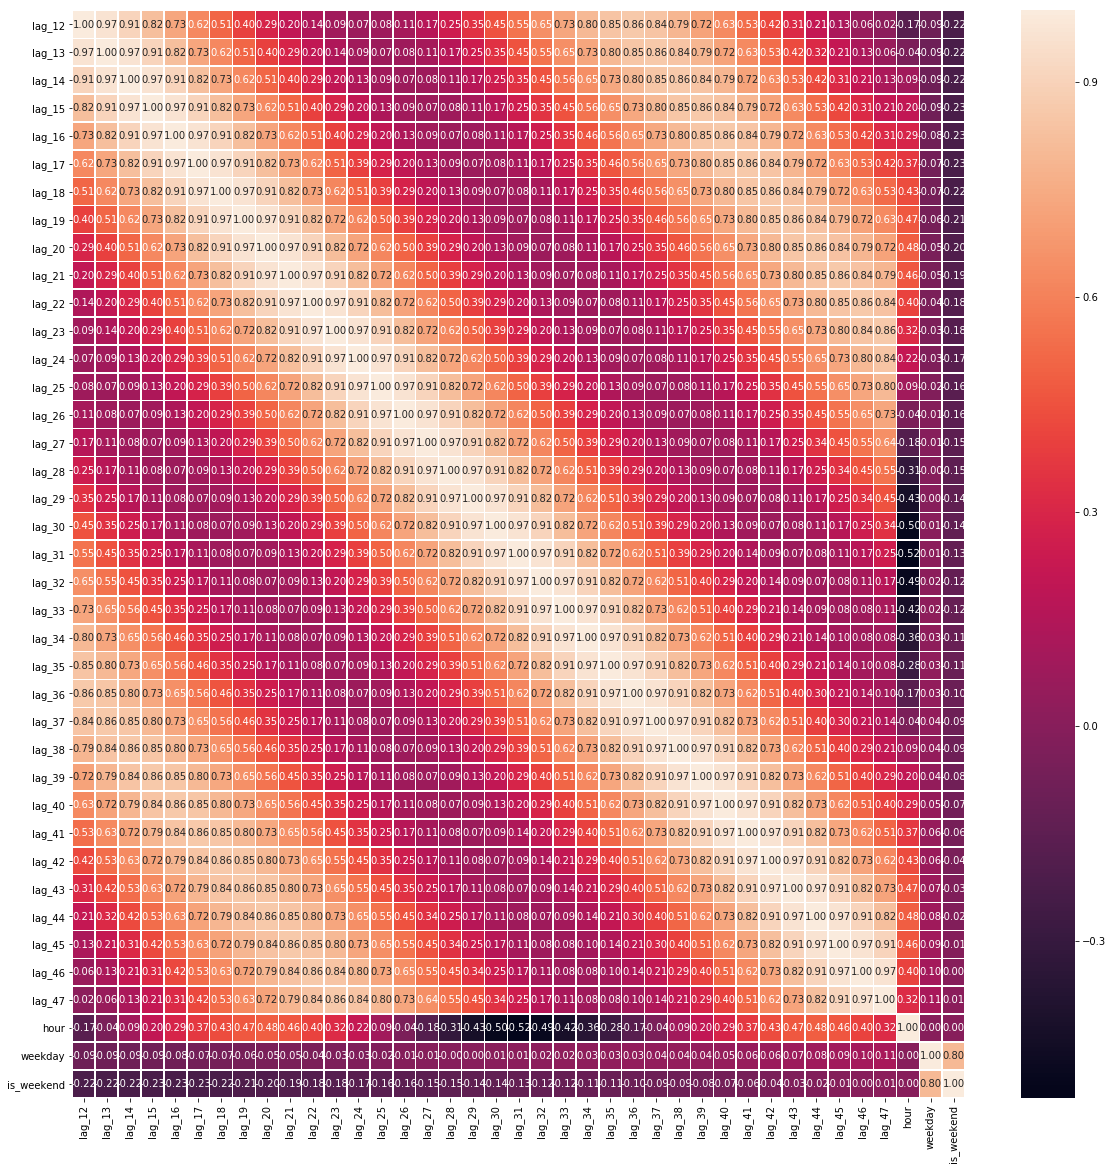

In [53]:
cm = X_train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5)

Действительно, налицо множество корреляций между нашими признаками, и даже видна "сезонность" в этих корреляциях на каждом 24-м лаге. Попробуем регуляризовать нашу модель и убрать несколько лишних переменных.

Обучите на полученных отмасштабированных данных Лассо-регрессию на кросс-валидации (`LassoCV`), снова передав в качестве параметра `cv` созданный ранее генератор разбиений. 

Постройте график прогнозов с интервалами и убедитесь, что ошибка на тестовой выборке практически не изменилась.

In [92]:
# Ваш код здесь
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=tsplt, verbose=True, n_jobs=1, random_state=12345)

In [93]:
lasso.fit(X_train_scaled, y_train)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


LassoCV(alphas=None, copy_X=True,
    cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=12345,
    selection='cyclic', tol=0.0001, verbose=True)

Замечательно, качество нас всё ещё устраивает, интервалы по-прежднему адекватные, посмотрим, сильно ли мы упростили модель. Воспользуйтесь предложенной функцией `getCoefficients` и скажите, сколько признаков вошли в модель с зануленными весами.

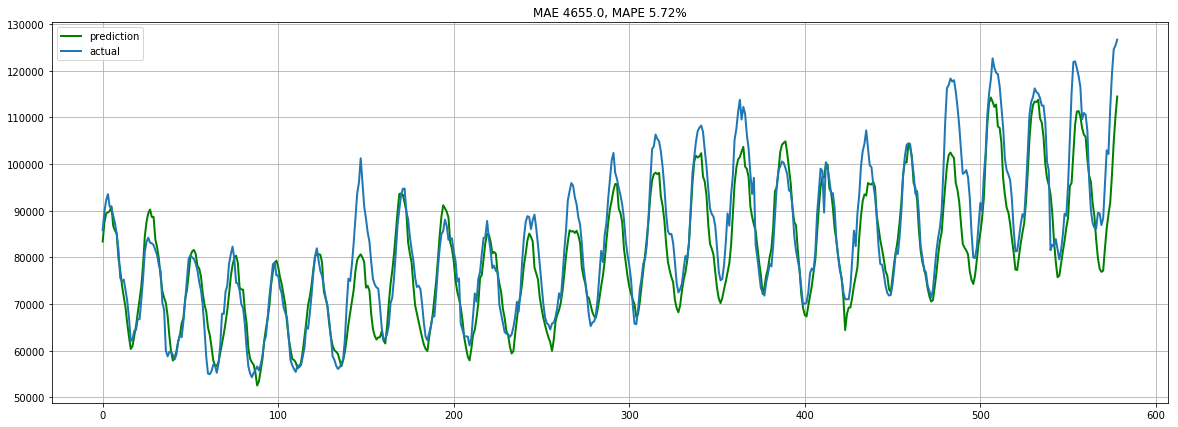

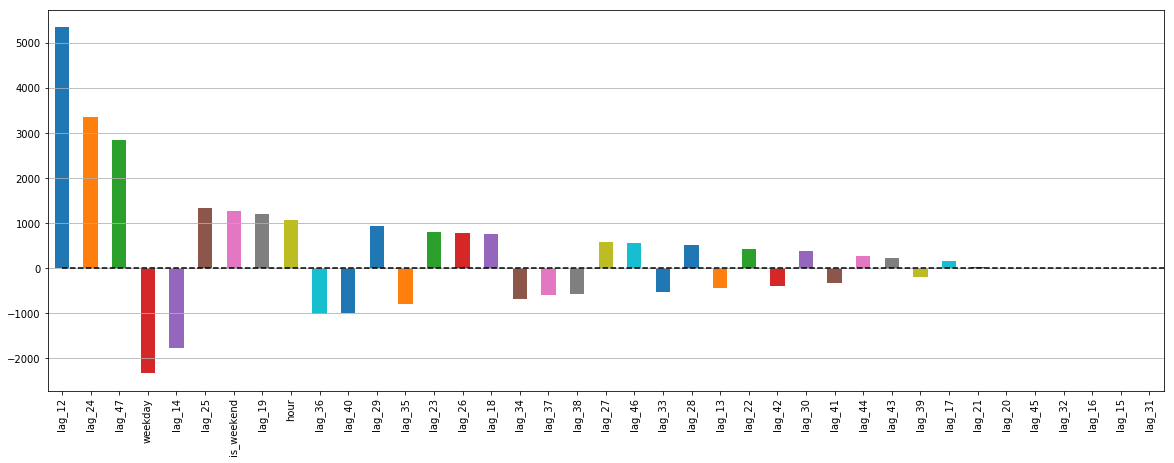

In [94]:
plotModelResults(lasso, X_train_scaled, X_test_scaled, plot_intervals=False)
plotCoefficients(lasso)

In [96]:
# plotModelResults(lasso, X_train_scaled, X_test_scaled, plot_intervals=True)
# plotCoefficients(lasso)

In [107]:
(np.abs(getCoefficients(lasso)) < 1e-6).sum()

coef    6
dtype: int64

<font color='red'>Вопрос 2.</font> Сколько коэффициентов линейной модели равны нулю (с точностью до 6-го знака)?

- 1
- 7
- 5
- 6

In [98]:
# Ответ: 4

Итак, признаковое пространство хоть немного, но удалось сократить. Что если пойти дальше и сжать наши линейно зависимые признаки в более компактное представление? Для этого воспользуемся методом главных компонент.

In [100]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

def plotPCA():
    """
    График накопленного процента объясненной дисперсии по компонентам
    """
    features = range(pca.n_components_)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.figure(figsize=(20, 10))
    plt.bar(features, variance)
    
    # дополнительно отметим уровень, при котором объяснены 95% дисперсии
    plt.hlines(y = 95, xmin=0, xmax=len(features), linestyles='dashed', colors='red')
    
    plt.xlabel('PCA components')
    plt.ylabel('variance')
    plt.xticks(features)
    plt.show()

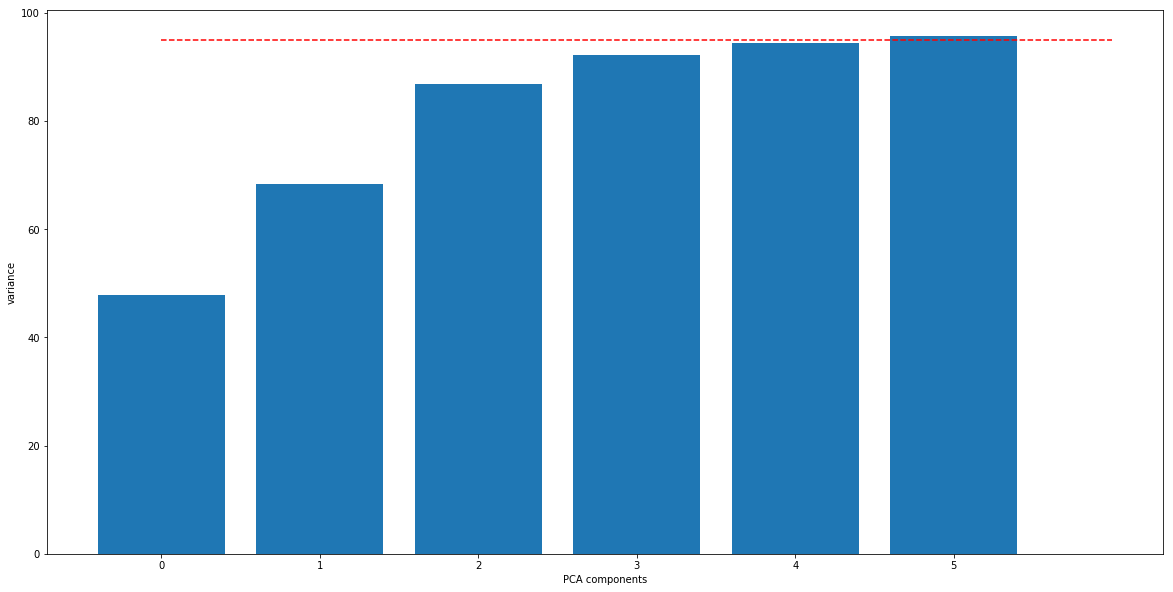

In [101]:
# Создайте объект PCA: pca
pca = PCA(0.95)
# Обучите pca на отмасштабированных данных
pca.fit(X_train_scaled)
# постройте график объясненной дисперсии
plotPCA()

<font color='red'>Вопрос 3.</font> Какое минимальное число компонент необходимо взять, чтобы объяснить минимум 95% всей дисперсии тренировочного датасета?

- 4
- 5
- 6
- 7

In [102]:
# Ответ: 2

Снова создайте объект `pca`, указав при этом оптимальное число компонент (объясняющее минимум 95% изменчивости). Затем создайте две новых переменных – `pca_features_train` и `pca_features_test`, присвоив им, соответственно, преобразованные при помощи PCA отмасштабированные датафреймы. 

In [103]:
pca = PCA(n_components=5)
pca_features_train = pca.fit_transform(X_train_scaled)
pca_features_test = pca.transform(X_test_scaled)

На полученных данных снова обучите простую линейную регрессию и постройте график прогноза.

In [104]:
lin_reg.fit(pca_features_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

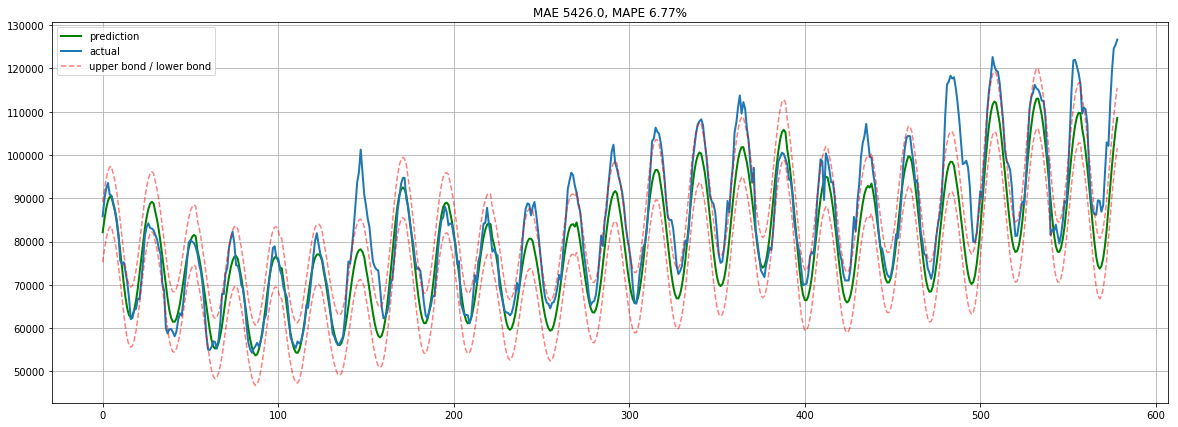

In [105]:
plotModelResults(lin_reg, pca_features_train, pca_features_test, plot_intervals=True)
# plotCoefficients(lin_reg)

<font color='red'>Вопрос 4.</font> Какая средняя абсолютная ошибка получилась у линейной регрессии, обученной на нескольких главных компонентах? 
- 5140
- 4917
- 6719
- 5434

In [46]:
# Ответ: 4